# Tarea Semanal 5: Simulación de un ADC (cuantización, muestreo y alias)
## Magdalena Noé
Se simulara un ADC incluyendo capacidad de muestrear a $f_s$ [Hz], con una señal analogica muestreada a $f′_S=k_O.f_S$, siendo $k_O$ el factor de sobremuestreo. Se adoptara una pontencia de ruido analogico igual al ruido de cuantizacion.

Primero se generaran dichas señales, con y sin oversampling, analizando sus diferencias.

Luego se aplicara un filtro pasabajos a la señal con oversampling, eliminando el alias, para apreciar la ventaja en definicion que trae esta practica. Asi mismo se generaran 3 casos en donde no se usa el filtro pasabajos de forma correcta, demostrando el efecto alias y las consecuencias que tiene en la señal.

- $f_c > fs/2$: dejando pasar componentes fuera de la banda original, que luego se replegarán (aliasing) al decimar
- $f_c << fs/2$: recortás contenido válido de la señal original 
- $f_c < fs/2$ pero N=1: Se respeta el limite de de Nyquist pero el filtro es de orden bajo
- $∄$: La señal no se filtra


### Librerias

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
import scipy.signal as sig

from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()

#### Parametros generales

In [ ]:
fs = 1000       # Frecuencia de muestreo [Hz]
ko = 10          # Factor de sobremuestreo
fs_os = fs * ko # Frec de muestreo con oversamp
ts_os = 1/fs_os
N = fs          # cantidad de muestras
N_os = N * ko   # cantidad de muestras con oversamp
fo = fs/N # [Hz]

Vmax = np.sqrt(2) #[Volts]
df_os = fs_os/N_os # resolución espectral

# RUIDO #
Vf = 2 #[Volts] 
B = 4 # Bits
q = Vf/2**(B)

kn = 1
Pq = q**2/12
Pn = kn * Pq # Pot ruido [Watts]

#### Generacion, contaminacion y cuantificacion de la señal

In [121]:
tt = np.arange(N) / fs
s = Vmax * np.sin(tt*2*np.pi*fo)

tt_os = np.arange(N_os) / fs_os
s_os = Vmax * np.sin(tt_os*2*np.pi*fo)

n = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N) # Ruido
sr = s + n
srq = np.round(sr / q) * q # Cuantizacion
nq = srq - sr

n_os = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N_os) # Ruido
sr_os = s_os + n_os
srq_os = np.round(sr_os / q) * q # Cuantizacion
nq_os = srq_os - sr_os # Error de cuantizacion


Graficamos las señales para apreciar sus diferencias

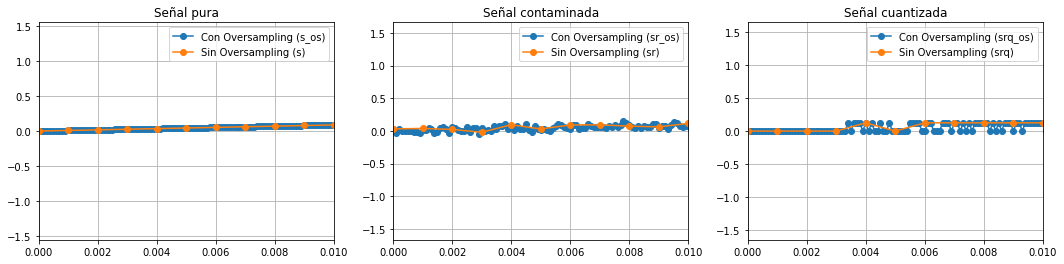

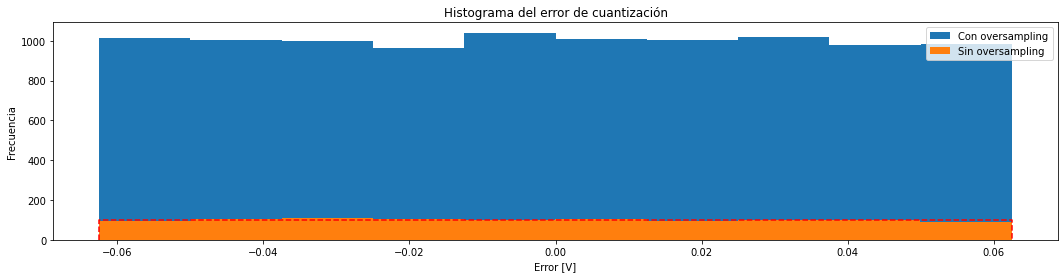

In [148]:
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
plt.plot(tt_os, s_os, 'o-', label='Con Oversampling (s_os)')
plt.plot(tt, s, 'o-', label='Sin Oversampling (s)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal pura")

plt.subplot(1,3,2)
plt.plot(tt_os, sr_os, 'o-', label='Con Oversampling (sr_os)')
plt.plot(tt, sr, 'o-', label='Sin Oversampling (sr)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal contaminada")

plt.subplot(1,3,3)
plt.plot(tt_os, srq_os, 'o-', label='Con Oversampling (srq_os)')
plt.plot(tt, srq, 'o-', label='Sin Oversampling (srq)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal cuantizada")
plt.show()

plt.figure(4, figsize=(18, 4))
bins = 10
plt.hist(nq_os, bins=bins, label="Con oversampling")
plt.hist(nq, bins=bins, label="Sin oversampling")
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title("Histograma del error de cuantización")
plt.xlabel("Error [V]"); plt.ylabel("Frecuencia"); plt.legend(); plt.show()

## Filtrado del alias apropiado
A continuacion se filtrara la señal con oversampling cuantificada con un filtro butter de cuarto grado y una frecuencia de corte que respeta el limite de Nyquist. Luego se decimara la misma para "eliminar" el efecto oversampling, tomando un valor de cada $k_o$ valores

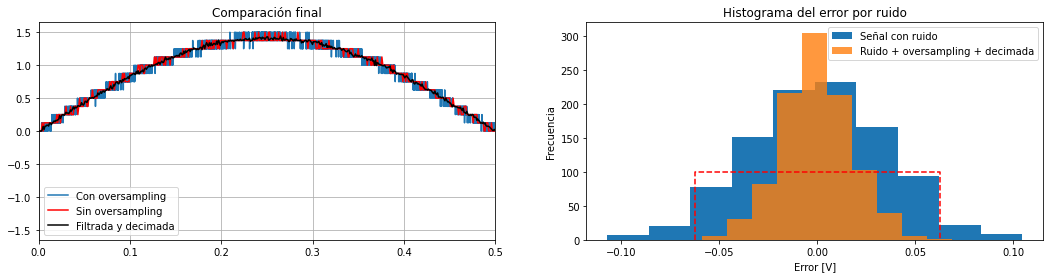

In [200]:
orden_filtro = 4
fc = fs/2 
f_nyquist = fs_os/2

Wn = fc/f_nyquist

coef_num, coef_den = butter(orden_filtro, Wn)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_decimada = s_filtrada[::ko]
tt_decimada = tt_os[::ko]

n_dec = s_decimada - s # Error con señal analogica
n_r = sr - s # Error con señal analogica

plt.figure(4, figsize=(18, 4))
plt.subplot(1,2,1)
plt.plot(tt_os, srq_os, label='Con oversampling')
plt.plot(tt, srq, label='Sin oversampling', color="red")
plt.plot(tt_decimada, s_decimada, label='Filtrada y decimada', color="black")
plt.title("Comparación final"); plt.legend(); plt.grid(); plt.xlim(0, 0.5)

plt.subplot(1,2,2)
bins = 10
plt.hist(n_r, bins=bins, label="Señal con ruido")
plt.hist(n_dec, bins=bins, alpha=0.8, label="Ruido + oversampling + decimada")
plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title("Histograma del error por ruido")
plt.xlabel("Error [V]"); plt.ylabel("Frecuencia"); plt.legend(); 
plt.show()


## Experimentacion de los filtros
En el caso anterior se respetaba el limite de Nyquist para crear el filtro ideal, donde se evita el efecto aliasing pero se pierde la menor cantidad de la señal posible.
Ahora experimentaremos con los 4 casos definidos al inicio.

##### Caso 1: $f_c > fs/2$

In [201]:
Wn_aliasing = (10*fc)/f_nyquist
orden_filtro = 4
# Filtrado
coef_num, coef_den = butter(orden_filtro, Wn)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_1 = s_filtrada[::ko]
tt_1 = tt_os[::ko]
n_1 = s_1 - s # Error con señal analogica

##### Caso 2: $f_c << fs/2$

In [202]:
Wn_recorte = (fc*0.1)/f_nyquist
orden_filtro = 4
# Filtrado
coef_num, coef_den = butter(orden_filtro, Wn)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_2 = s_filtrada[::ko]
tt_2 = tt_os[::ko]
n_2 = s_2 - s # Error con señal analogica

##### Caso 3: Orden bajo

In [203]:
Wn = fc/f_nyquist
orden_filtro = 1
# Filtrado
coef_num, coef_den = butter(orden_filtro, Wn)
s_filtrada = lfilter(coef_num, coef_den, srq_os)

# Decimación
s_3 = s_filtrada[::ko]
tt_3 = tt_os[::ko]
n_3 = s_3 - s # Error con señal analogica

##### Caso 4: Sin filtro

In [204]:
# Decimación
s_4 = srq_os[::ko]
tt_4 = tt_os[::ko]
n_4 = s_4 - s # Error con señal analogica

## Comparacion grafica

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1296x288 with 0 Axes>

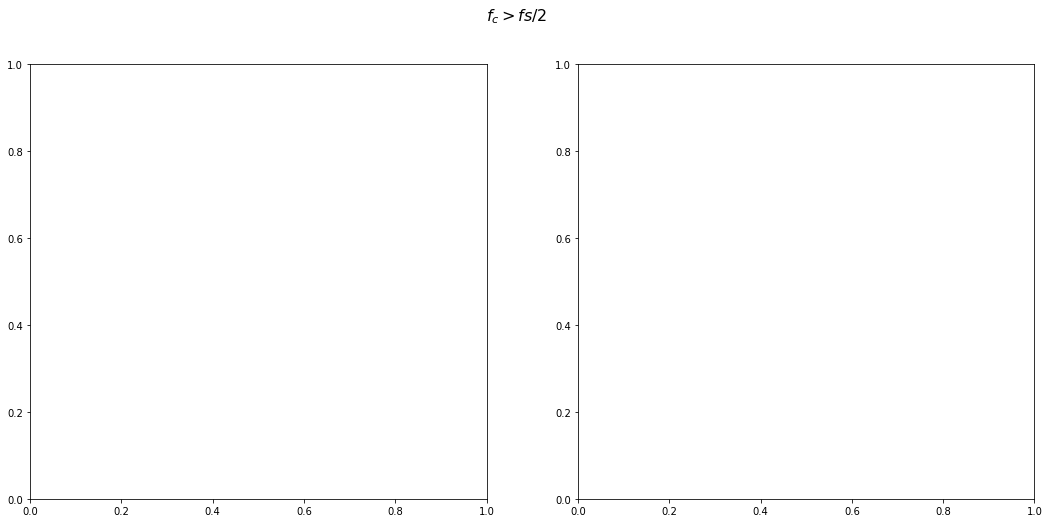

In [ ]:
arr_s = [s_1, s_2, s_3, s_4]
arr_tt = [tt_1, tt_2, tt_3, tt_4]
arr_n = [n_1, n_2, n_3, n_4]
arr_titulos = ["$f_c > fs/2$","$f_c << fs/2$","Orden bajo","Sin filtro"]

plt.figure(4, figsize=(18, 4))
bins = 10
for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(arr_titulos[i], fontsize=16)

    #plt.subplot(4,2,(i+1))
    #axs[0, 0].plot(tt_os, srq_os, label='Con oversampling')
    #axs[0, 0].plot(tt, srq, label='Sin oversampling', color="red")
    axs[0].plot(arr_tt[i], arr_s[i], label='Filtrada y decimada', color="black")
    axs[0].title("Comparación final"); plt.legend(); plt.grid(); plt.xlim(0, 0.5)

    #plt.subplot(4,2,(i+2))
    
    #axs[0, 0].hist(n_r, bins=bins, label="Señal con ruido")
    axs[1].hist(arr_n[i], bins=bins, alpha=0.8, label="Ruido + oversampling + decimada")
    axs[1].plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
    axs[1].title("Histograma del error por ruido")
    axs[1].xlabel("Error [V]"); plt.ylabel("Frecuencia"); plt.legend(); 
plt.show()

In [ ]:
def graficar_funcion(abs,ord,leg="",label_y="",label_x="",titulo="",xlim=0,show=1):
    for k in np.arange(len(ord)):
        plt.plot(abs, ord[k], label=leg[k])
    if(xlim):
        plt.xlim(0, xlim)
    else:
        plt.axis('tight')

    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(titulo)
    plt.grid()
    plt.legend()
    if(show): #Para manejar subplots por fuera de la funcion
        plt.show()
    return

def graficar_frec(XX, N, f0=0, titulo=""):
    XX = np.roll(XX, N // 2) # Shifteo

    k = np.linspace(-2 * np.pi, 2 * np.pi, N) # Eje de frecuencias de -2pi a 2pi
    wo_pos = k[N // 2 + f0] # Posicion del delta positivo
    wo_neg = k[N // 2 - f0] # Posicion del delta negativo

    plt.figure(figsize=(18, 4))
    plt.stem(k, np.abs(XX), use_line_collection=True, label="|X[k]|") # grafico para funciones discretas
    plt.title(titulo)
    plt.xlabel(r"${\omega}  [rad/s]$")
    plt.ylabel("|X[k]|")
    plt.grid(True)

    # Destaco valores importantes sobre el eje de radianes (0, pi, 2pi, wo y sus negativos)
    if(f0 == 0): # En caso de que la señal no tenga frecuencia fundamental
        x_ticks = [-2*np.pi, -np.pi, 0, np.pi, 2*np.pi]
        x_labels = [r"$-2\pi$", r"$-\pi$", "0", r"$\pi$", r"$2\pi$"]
    else:
        x_ticks = [-2*np.pi, -np.pi, 0, np.pi, 2*np.pi, wo_pos, wo_neg]
        x_labels = [r"$-2\pi$", r"$-\pi$", "0", r"$\pi$", r"$2\pi$", r"$fo*2\pi$", r"$-fo*2\pi$"]

    plt.xticks(x_ticks, x_labels)

    plt.legend()
    plt.show()